In [1]:
import yfinance as yf
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from PyEMD import CEEMDAN, Visualisation

In [2]:
# constants
today = '2022-01-01'
ticker_dct = {
    'PETR4.SA' : ['2015-01-01',today],
    'VALE3.SA' : ['2015-01-01',today],
    'BBDC4.SA' : ['2015-01-01',today],
    'ITUB4.SA' : ['2015-01-01',today],
    'MGLU3.SA' : ['2015-01-01',today],
    'BBAS3.SA' : ['2015-01-01',today]
}
target_feature = "Adj Close"

In [3]:
def fetch_stock_data(ticker_dct):
    for k,v in ticker_dct.items():
        ticker_dct[k] = yf.download(k, v[0], v[1])
    return ticker_dct

dfs = fetch_stock_data(ticker_dct)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


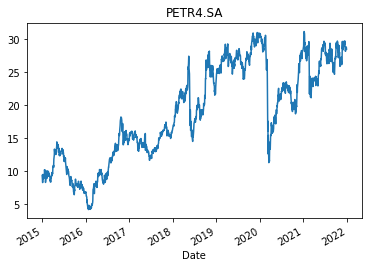

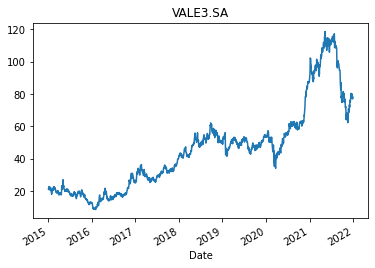

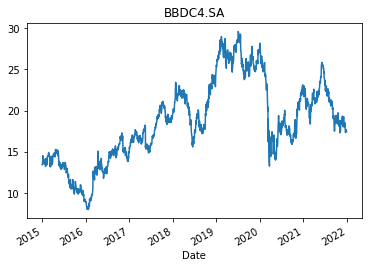

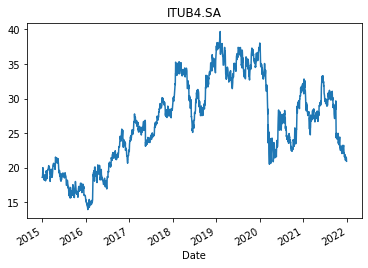

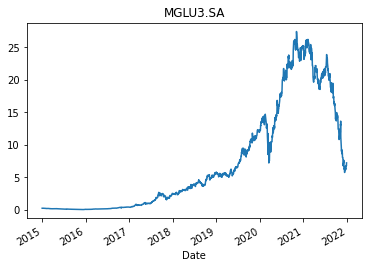

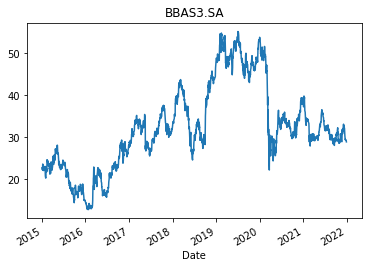

In [4]:
def visualize_close_prices(dfs):
    '''
    This function will visualize the closing prices associated
    to a given input dataframe
    '''
    for k,v in dfs.items():
        plt.title(k)
        v.Close.plot()
        plt.show()
        
visualize_close_prices(dfs)

# Decompose with CEEMDAN

In [5]:
ceemdan_objs = {}

imfs_per_ticker = {
    ticker : None for ticker in ticker_dct.keys()
}

ceemdan_obj_per_ticker = {
    ticker : None for ticker in ticker_dct.keys()
}

for ticker in ticker_dct.keys():

    ceemdan = CEEMDAN()
    signal = dfs[ticker][target_feature].tolist()

    c_imfs = ceemdan.ceemdan(signal)

    imfs_per_ticker[ticker] = c_imfs
    ceemdan_obj_per_ticker[ticker] = ceemdan

In [63]:
for ticker in ticker_dct.keys():
    print(f"{ticker} = {len(imfs_per_ticker[ticker])}")

PETR4.SA = 8
VALE3.SA = 8
BBDC4.SA = 8
ITUB4.SA = 8
MGLU3.SA = 7
BBAS3.SA = 8


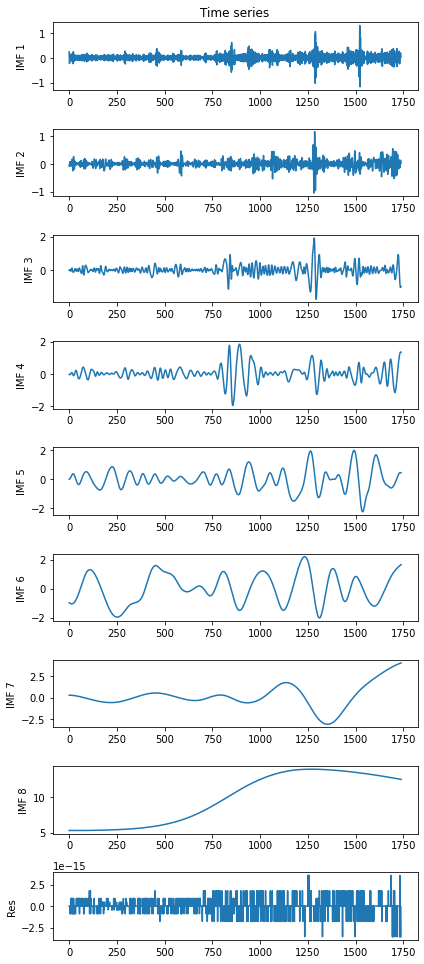

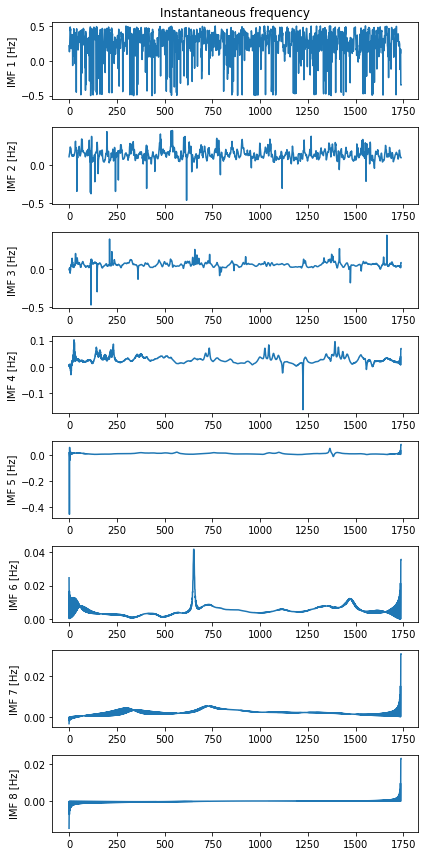

In [65]:
def visualize_imfs_from_ticker(imfs_per_ticker, ticker, dfs):
    t = dfs[ticker].index.tolist()
    t_int = np.arange(0, len(t), 1)

    ceemdan = ceemdan_obj_per_ticker[ticker]

    visual = Visualisation(ceemdan)
    visual.plot_imfs()
    visual.plot_instant_freq(t_int)

visualize_imfs_from_ticker(imfs_per_ticker, "PETR4.SA", dfs)

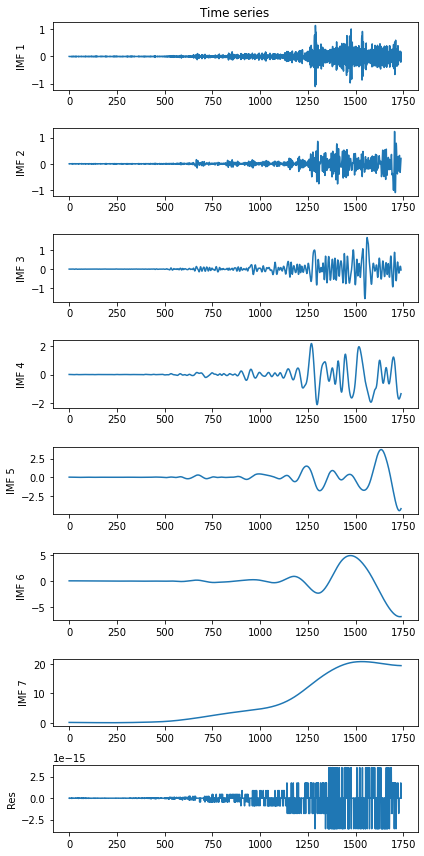

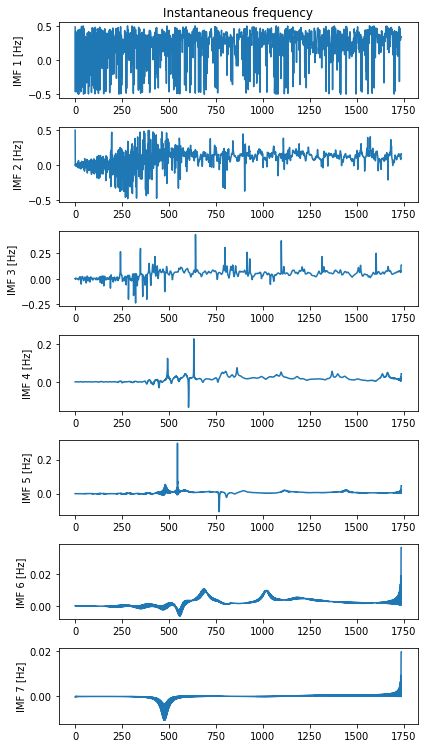

In [66]:
visualize_imfs_from_ticker(imfs_per_ticker, "MGLU3.SA", dfs)

In [67]:
def get_nth_imf_from_ticker(imfs_per_ticker, n, ticker):
    return imfs_per_ticker[ticker][n].tolist()

def min_max(series):
    num = [x - min(series) for x in series]
    min_max_diff = (max(series) - min(series))
    return [x / min_max_diff for x in num]

target_ticker = "PETR4.SA"
imf_dtw_distances = {}
for imf_level in range(1,7):
    distance_results = {}
    for ticker in ticker_dct.keys():
        target_series = get_nth_imf_from_ticker(imfs_per_ticker, imf_level, target_ticker)
        current_comparison_series = get_nth_imf_from_ticker(imfs_per_ticker, imf_level, ticker)

        target_series = min_max(target_series)
        current_comparison_series = min_max(current_comparison_series)

        distance_results[ticker], _ = fastdtw(target_series, current_comparison_series)
    imf_dtw_distances[f"IMF{imf_level}"] = distance_results

<AxesSubplot:>

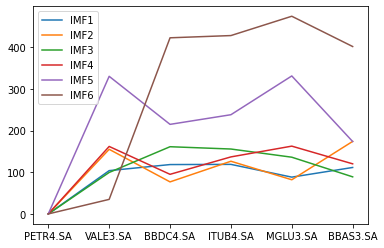

In [68]:
pd.DataFrame().from_dict(imf_dtw_distances).plot()

# Find Stocks Similar to PETR4.SA

In [20]:
# benchmark the dates to start from 0
for ticker, df in dfs.items():
    dates = df.index.values
    date_map = {date:idx for idx, date in enumerate(dates)}
    
    dfs[ticker]['benchmark_date'] = dfs[ticker].index.map(date_map)

In [21]:
shop_df = dfs['PETR4.SA']
distances = {}
for k,v in dfs.items():
    max_d = v['benchmark_date'].max()
    benchmark = np.array(shop_df[shop_df['benchmark_date'].between(0, max_d)]['Close'].values)
    
    y = np.array(v.Close.values)
    d,p = fastdtw(benchmark, y)
    distances[k] = d
    break

In [28]:
len(benchmark)

1738

In [29]:
len(y)

1738

In [ ]:
distances